In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.nn.utils import prune
import matplotlib.pyplot as plt


In [2]:
# Transform and DataLoader for CIFAR-10
transform = transforms.Compose(
    [transforms.RandomCrop(32, padding=4),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [3]:
from torchvision.models import resnet18

# Load the pretrained ResNet18 model
net = resnet18(pretrained=True)
# Replace the final fully connected layer
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 10)
net = net.to('cuda' if torch.cuda.is_available() else 'cpu')


/home/asu/miniconda3/envs/dl_pytorch_hf/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asu/miniconda3/envs/dl_pytorch_hf/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
def prune_model(model, amount):
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            prune.l1_unstructured(module, name='weight', amount=amount)
            prune.remove(module, 'weight')
        elif isinstance(module, nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=amount)
            prune.remove(module, 'weight')



def calculate_sparsity(model):
    total_params = 0
    zero_params = 0
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            total_params += module.weight.nelement()
            zero_params += torch.sum(module.weight == 0).item()
    return 100.0 * zero_params / total_params


In [5]:
# Training settings
device = 'cuda' if torch.cuda.is_available() else 'cpu'
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

def train(epoch, net, trainloader, optimizer, criterion):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)

        # 计算L1正则化项
        # l1_penalty = 0
        # for param in model.parameters():
        #     l1_penalty += torch.norm(param, 1)
            
        loss = criterion(outputs, targets)

        
        loss.backward()
        
        optimizer.step()

        

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    accuracy = 100. * correct / total
    print(f'Epoch {epoch}, Loss: {train_loss/len(trainloader)}, Accuracy: {accuracy}')
    return accuracy

def test(net, testloader, criterion):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    accuracy = 100. * correct / total
    sparsity = calculate_sparsity(net)
    print(f'Test Loss: {test_loss/len(testloader)}, Accuracy: {accuracy}, Sparsity: {sparsity:.2f}')
    return accuracy

# Lists to store accuracy for plotting
pruning_amounts = [0.1 * i for i in range(0, 10)]
train_accuracies = {amount: [] for amount in pruning_amounts}
test_accuracies = {amount: [] for amount in pruning_amounts}
sparsity_accuracies = {amount: [] for amount in pruning_amounts}

# Training and pruning for different amounts
for amount in pruning_amounts:
    net = resnet18(pretrained=True)
    num_ftrs = net.fc.in_features
    net.fc = nn.Linear(num_ftrs, 10)
    net = net.to(device)
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

    print(f'Pruning amount: {amount}')
    for epoch in range(0, 150):
        sparsity = calculate_sparsity(net)
        print(f'Pruning performed at epoch {epoch} for amount {amount}')
        print(f'Sparsity after pruning: {sparsity:.2f}%')
        train_acc = train(epoch, net, trainloader, optimizer, criterion)
        test_acc = test(net, testloader, criterion)
        scheduler.step()
        sparsity = calculate_sparsity(net)
        sparsity_accuracies[amount].append(sparsity)
        train_accuracies[amount].append(train_acc)
        test_accuracies[amount].append(test_acc)
        
        if epoch % 1 == 0:
            prune_model(net, amount=amount)  # Prune the specified amount
            sparsity = calculate_sparsity(net)
            print(f'Pruning performed at epoch {epoch} for amount {amount}')
            print(f'Sparsity after pruning: {sparsity:.2f}%')


Pruning amount: 0.0
Pruning performed at epoch 0 for amount 0.0
Sparsity after pruning: 0.00%
Epoch 0, Loss: 3.023151677587758, Accuracy: 15.778
Test Loss: 2.059959727525711, Accuracy: 20.55, Sparsity: 0.00
Pruning performed at epoch 0 for amount 0.0
Sparsity after pruning: 0.00%
Pruning performed at epoch 1 for amount 0.0
Sparsity after pruning: 0.00%
Epoch 1, Loss: 1.9030257731752322, Accuracy: 26.548
Test Loss: 1.7462077140808105, Accuracy: 34.25, Sparsity: 0.00
Pruning performed at epoch 1 for amount 0.0
Sparsity after pruning: 0.00%
Pruning performed at epoch 2 for amount 0.0
Sparsity after pruning: 0.00%
Epoch 2, Loss: 1.6390666979962907, Accuracy: 38.2
Test Loss: 1.5630007219314574, Accuracy: 42.33, Sparsity: 0.00
Pruning performed at epoch 2 for amount 0.0
Sparsity after pruning: 0.00%
Pruning performed at epoch 3 for amount 0.0
Sparsity after pruning: 0.00%
Epoch 3, Loss: 1.4988376536332737, Accuracy: 44.808
Test Loss: 1.4363923811912536, Accuracy: 48.33, Sparsity: 0.00
Prunin

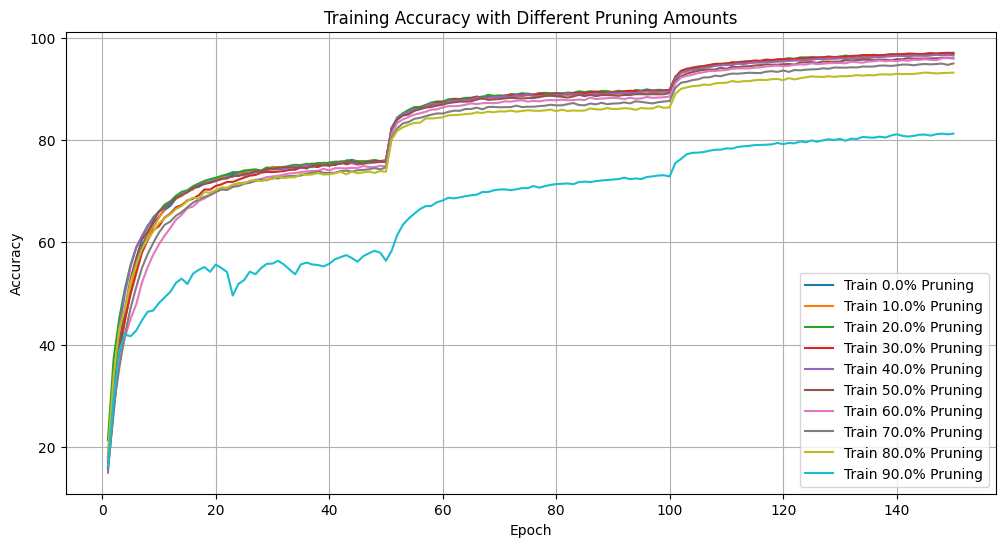

In [7]:
plt.figure(figsize=(12, 6))
# Train Accuracy
for amount in pruning_amounts:
    ratio = amount*100
    plt.plot(list(range(1, 151)), train_accuracies[amount], label=f'Train {ratio:.1f}% Pruning')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy with Different Pruning Amounts')
plt.legend()
plt.grid(True)
plt.show()


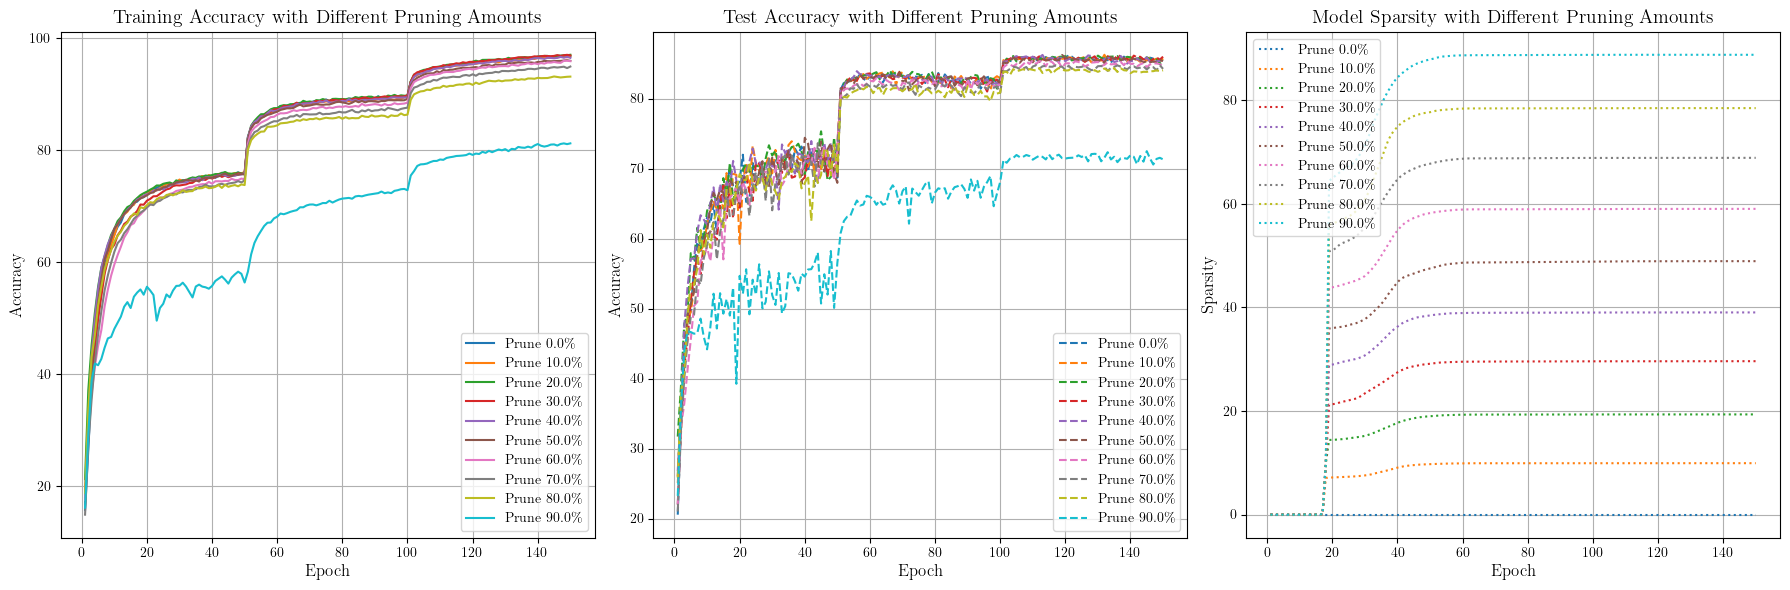

In [15]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10
})

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

for amount in pruning_amounts:
    ax1.plot(list(range(1, 151)), train_accuracies[amount], label=f'Prune {amount*100:.1f}\\%')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('Training Accuracy with Different Pruning Amounts')
ax1.legend()
ax1.grid(True)

for amount in pruning_amounts:
    ax2.plot(list(range(1, 151)), test_accuracies[amount], linestyle='--', label=f'Prune {amount*100:.1f}\\%')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Test Accuracy with Different Pruning Amounts')
ax2.legend()
ax2.grid(True)

for amount in pruning_amounts:
    ax3.plot(list(range(1, 151)), sparsity_accuracies[amount], linestyle=':', label=f'Prune {amount*100:.1f}\\%')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Sparsity')
ax3.set_title('Model Sparsity with Different Pruning Amounts')
ax3.legend()
ax3.grid(True)

# 调整布局并显示图形
plt.tight_layout()
plt.show()


In [19]:
!pip install SciencePlots


In [24]:
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','ieee'])

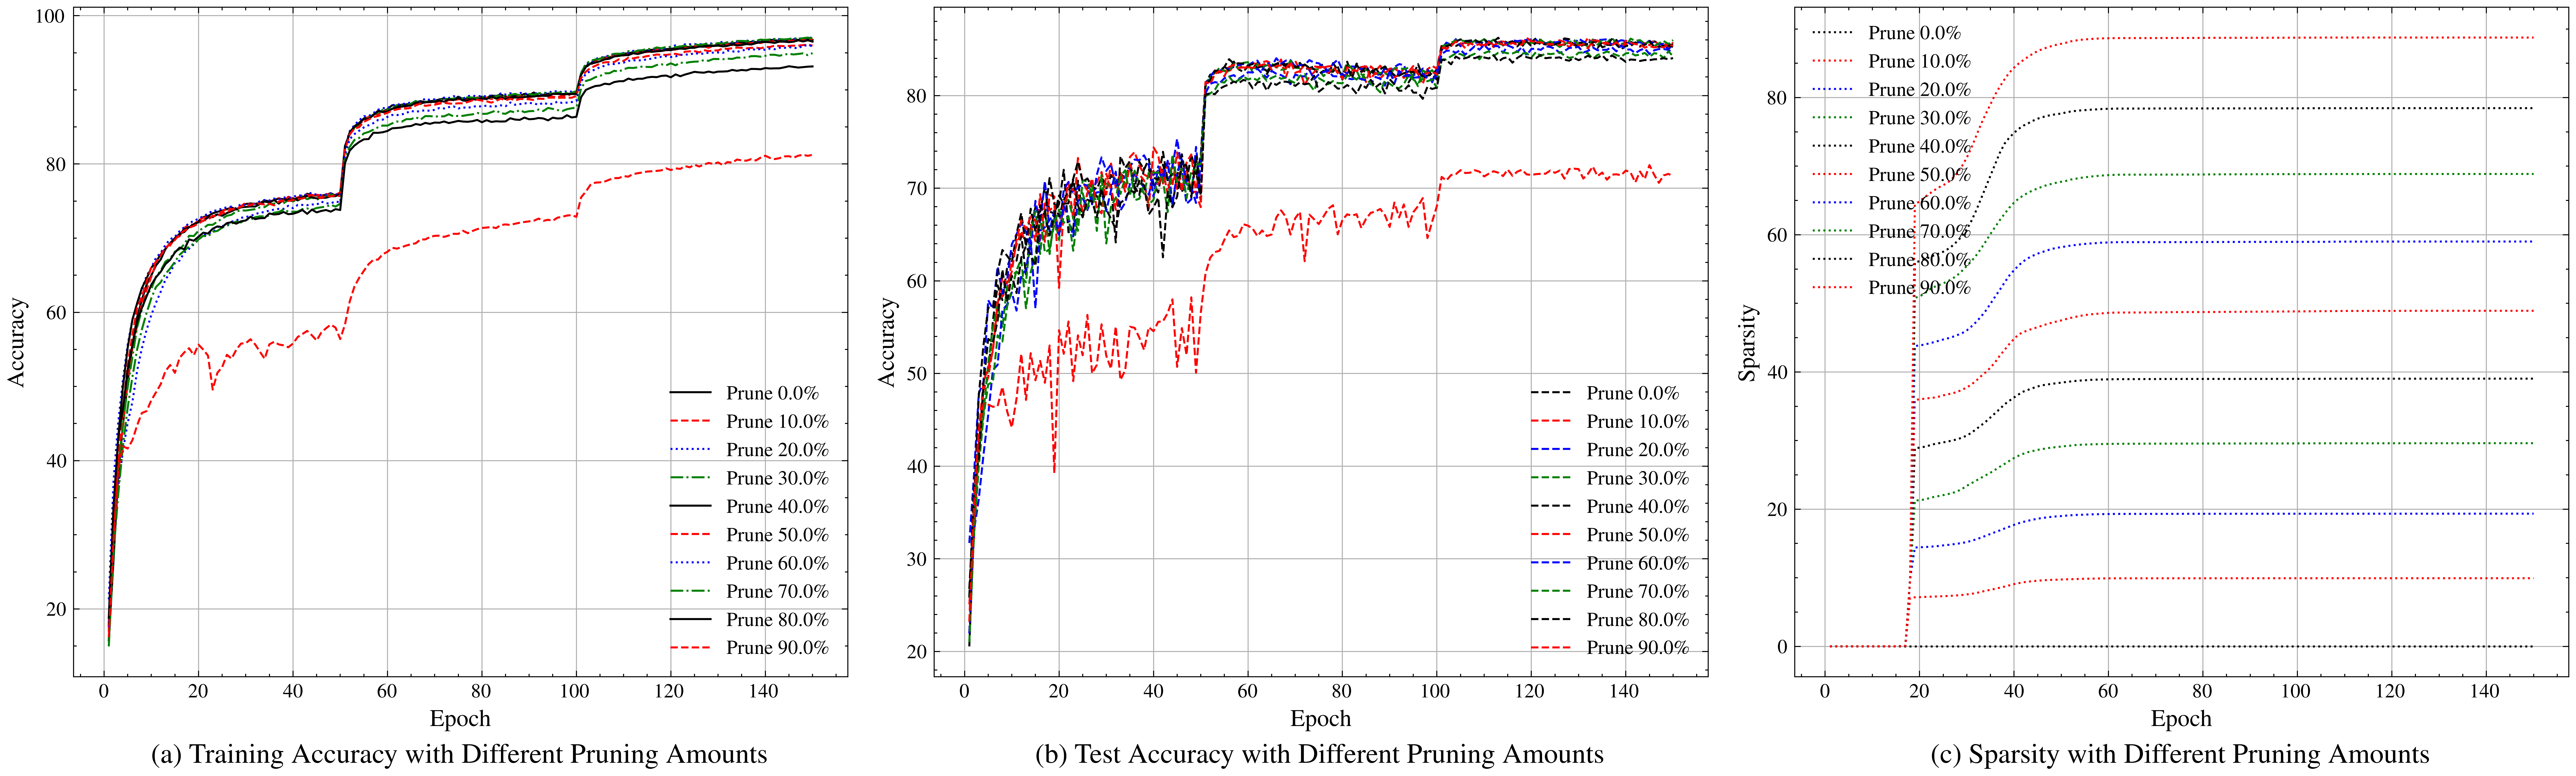

In [32]:

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Times New Roman"],
#     "axes.titlesize": 14,
#     "axes.labelsize": 12,
#     "xtick.labelsize": 10,
#     "ytick.labelsize": 10,
#     "legend.fontsize": 10
# })


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

for amount in pruning_amounts:
    ax1.plot(list(range(1, 151)), train_accuracies[amount], label=f'Prune {amount*100:.1f}\\%')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.text(0.5, -0.1, '(a) Training Accuracy with Different Pruning Amounts', fontsize=14,  transform=ax1.transAxes, va='top', ha='center')
ax1.legend()
ax1.grid(True)

for amount in pruning_amounts:
    ax2.plot(list(range(1, 151)), test_accuracies[amount], linestyle='--', label=f'Prune {amount*100:.1f}\\%')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.text(0.5, -0.1, '(b) Test Accuracy with Different Pruning Amounts',fontsize=14, transform=ax2.transAxes, va='top', ha='center')
ax2.legend()
ax2.grid(True)

for amount in pruning_amounts:
    ax3.plot(list(range(1, 151)), sparsity_accuracies[amount], linestyle=':', label=f'Prune {amount*100:.1f}\\%')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Sparsity')
ax3.text(0.5, -0.1, '(c) Sparsity with Different Pruning Amounts',fontsize=14, transform=ax3.transAxes, va='top', ha='center')
ax3.legend()
ax3.grid(True)


# 调整布局并显示图形
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
